# Imports

In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

# Data

In [7]:
DATA_PATH = "/Users/pbezuhov/git/Kaggle/data/ghouls/"

train = pd.read_csv(DATA_PATH + "train.csv")
test  = pd.read_csv(DATA_PATH + "test.csv")

print("Shape of train: {}".format(train.shape))
print("Shape of test: {} ".format(test.shape))

Shape of train: (371, 7)
Shape of test: (529, 6) 


### Split into predictors, target, and id

In [8]:
train_id = train.id
test_id = test.id
train_y = train.type.map({"Ghoul": 0, "Goblin": 1, "Ghost": 2})

train_x = train.drop(["id", "type"], axis=1)
test_x = test.drop("id", axis=1)

### Get dummies for categorical variables

In [9]:
train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

# Modeling

### Imports

In [10]:
# Massive amounts of model imports
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

kfold = StratifiedKFold()

def score_model(model):
    score = cross_val_score(model, train_x, train_y, cv=kfold, n_jobs=1, scoring="accuracy")
    print(score)
    print("\nAverage is ...")
    print(sum(score) / len(score))

# It's good to try out different models to see what performs best

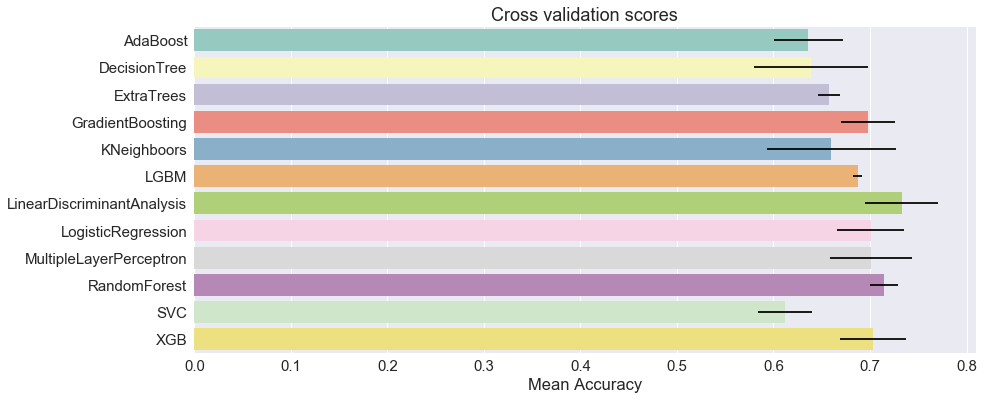

In [22]:
# Modeling step Test differents algorithms 
classifiers = [
                AdaBoostClassifier(
                    DecisionTreeClassifier(random_state = 17),
                    random_state = 17, learning_rate = 0.1
                ),
                DecisionTreeClassifier(random_state = 17),
                ExtraTreesClassifier(random_state = 17),
                GradientBoostingClassifier(random_state=17),
                KNeighborsClassifier(),
                LGBMClassifier(),
                LinearDiscriminantAnalysis(),
                LogisticRegression(random_state = 17),
                MLPClassifier(random_state = 17),
                RandomForestClassifier(random_state = 17),
                SVC(random_state=17),
                XGBClassifier()
              ]

cv_results = [cross_val_score(classifier, train_x, y=train_y, scoring="accuracy", cv=kfold) for classifier in classifiers]

cv_means = [cv_result.mean() for cv_result in cv_results]
cv_std = [cv_result.std() for cv_result in cv_results]

cv_results = pd.DataFrame({
                        "CrossValMeans":cv_means,
                        "CrossValerrors": cv_std,
                        "Algorithm":[
                            "AdaBoost",
                            "DecisionTree",
                            "ExtraTrees",
                            "GradientBoosting",
                            "KNeighboors",
                            "LGBM",
                            "LinearDiscriminantAnalysis",
                            "LogisticRegression",
                            "MultipleLayerPerceptron",
                            "RandomForest",
                            "SVC",
                            "XGB"
                        ]})

plt.figure(figsize=(14, 6))
sns.barplot("CrossValMeans","Algorithm", data=cv_results, palette="Set3", orient="h", **{'xerr':cv_std})
sns.set(font_scale=1.5)
plt.xlabel("Mean Accuracy")
plt.ylabel("")
_ = plt.title("Cross validation scores")

### Seeing these scores, I'm going to create an ensemble classifer using LinearDiscriminantAnalysis, GradientBoost, RandomForest, and XGB

In [36]:
lda_model = LinearDiscriminantAnalysis()
gbc_model = GradientBoostingClassifier(random_state=17)
rfc_model = RandomForestClassifier(random_state = 17)
xgb_model = XGBClassifier()

### Train models

In [37]:
lda_model.fit(train_x, train_y)
gbc_model.fit(train_x, train_y)
rfc_model.fit(train_x, train_y)
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Creating model

In [44]:
final_model = VotingClassifier(estimators=[
                                        ("LDA", lda_model),                                    
                                        ("GBC", gbc_model),
                                        ("RFC",rfc_model),
                                        ("XGB", xgb_model),
                                      ], voting='soft')

#### Fit and score model
final_model = final_model.fit(train_x, train_y)
score_model(final_model)

[ 0.75806452  0.73387097  0.70731707]

Average is ...
0.733084185681


### Getting predictions

In [45]:
prediction = final_model.predict(test_x)

ghoul_map = {0: "Ghoul", 1: "Goblin", 2: "Ghost"}
mapper = lambda t: ghoul_map[t]

vfunc = np.vectorize(mapper)
prediction = vfunc(prediction)

# Save submission to CSV

In [46]:
submission = pd.DataFrame({
    'id': test_id,
    'type': prediction
})

submission.to_csv('/Users/pbezuhov/git/Kaggle/submissions/ghouls_no_gbc.csv',index=False)